In [2]:
import sys
sys.path.append('../Common')
import pandas as pd
import yfinance as yf
import CommonYFinance, CommonBinance, CommonMT5, CommonMongoDBConnector, CommonBacktest
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.metrics import mean_squared_error
import seaborn as sns

Các hàm sử dụng

In [3]:
def calculate_dtosc(data, k_period=21, d_period=13, mov_avg1_period=8, mov_avg2_period=8):
    # %K
    data['Lowest_Low'] = data['Low'].rolling(window=k_period).min()
    data['Highest_High'] = data['High'].rolling(window=k_period).max()
    data['%K'] = ((data['Close'] - data['Lowest_Low']) / (data['Highest_High'] - data['Lowest_Low'])) * 100
    
    # MovAvg1
    data['MovAvg1'] = data['%K'].rolling(window=mov_avg1_period).mean()
    
    # MovAvg2
    data['MovAvg2'] = data['MovAvg1'].rolling(window=mov_avg2_period).mean()
    
    # %D
    data['%D'] = data['MovAvg1'].rolling(window=d_period).mean()

Lấy dữ liệu

In [4]:
symbol = 'AUDJPY=X'

Daily_Data = CommonYFinance.CommonYFinance.loaddataYFinance2(symbol, "5y", "1d")
Hour_data = CommonYFinance.CommonYFinance.loaddataYFinance2(symbol, "2y", "1h")

AttributeError: type object 'CommonYFinance' has no attribute 'loaddataYFinance2'

In [ ]:
# Tính động lượng cho khung thời gian ngày
calculate_dtosc(Daily_Data)
Daily_Data

Date      Time       Open       High        Low      Close  \
0     2019-03-18  00:00:00  79.000000  79.406998  78.980003  79.000000   
1     2019-03-19  00:00:00  79.053001  79.182999  78.879997  79.057999   
2     2019-03-20  00:00:00  78.970001  79.144997  78.774002  78.949997   
3     2019-03-21  00:00:00  78.910004  79.318001  78.730003  78.928001   
4     2019-03-22  00:00:00  78.730003  78.835999  77.789001  78.737999   
...          ...       ...        ...        ...        ...        ...   
1301  2024-03-12  00:00:00  97.046997  97.668999  97.013000  97.065002   
1302  2024-03-13  00:00:00  97.526001  97.926003  97.240997  97.526001   
1303  2024-03-14  00:00:00  97.830002  97.928001  97.424004  97.830002   
1304  2024-03-15  00:00:00  97.563004  97.949997  97.264000  97.563004   
1305  2024-03-18  00:00:00  97.817001  98.009003  97.612000  97.893997   

      Volume  Lowest_Low  Highest_High         %K    MovAvg1    MovAvg2  \
0          0         NaN           NaN        NaN        NaN        NaN   
1          0         NaN           NaN        NaN        NaN        NaN   
2          0         NaN           NaN        NaN        NaN        NaN   
3          0         NaN           NaN        NaN        NaN        NaN   
4          0         NaN           NaN        NaN        NaN        NaN   
...      ...         ...           ...        ...        ...        ...   
1301       0   96.899002     99.045998   7.731752  44.579533  64.779143   
1302       0   96.899002     99.045998  29.203549  42.121401  60.050672   
1303       0   96.899002     99.045998  43.362910  39.541912  55.392261   
1304       0   96.899002     99.045998  30.927007  36.063357  50.727131   
1305       0   96.899002     99.045998  46.343604  36.282435  46.802432   

             %D  
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4           NaN  
...         ...  
1301  73.744167  
1302  70.192283  
1303  66.262882  
1304  62.212186  
1305  58.205982  

[1306 rows x 13 columns]

In [ ]:
# Lấy kết quả của Daily_Data để đưa vào Hour_data
Hour_data = pd.merge(Hour_data, Daily_Data[['Date', 'MovAvg1', 'MovAvg2']], on='Date', how='left')
Hour_data.rename(columns={'MovAvg1': 'D_Movavg1'}, inplace=True)
Hour_data.rename(columns={'MovAvg2': 'D_Movavg2'}, inplace=True)

#Tính toán động lượng đối với khung thời gian giờ
calculate_dtosc(Hour_data)

# Xóa các dòng có giá trị NaN trong cột 'MovAvg1'
Hour_data.dropna(inplace=True)
Hour_data.drop(columns= 'Volume')
Hour_data.head(1000)

Date      Time       Open       High        Low      Close  Volume  \
39  2022-03-21  22:00:00  88.333000  88.448997  88.319000  88.394997       0   
40  2022-03-21  23:00:00  88.398003  88.503998  88.378998  88.446999       0   
41  2022-03-22  00:00:00  88.443001  88.625999  88.400002  88.564003       0   
42  2022-03-22  01:00:00  88.566002  88.603996  88.379997  88.398003       0   
43  2022-03-22  02:00:00  88.400002  88.581001  88.386002  88.570000       0   

    D_Movavg1  D_Movavg2  Lowest_Low  Highest_High         %K    MovAvg1  \
39  87.150294  82.988475   87.809998     88.448997  91.549161  78.003069   
40  87.150294  82.988475   87.809998     88.503998  91.786861  79.382950   
41  86.955600  83.848493   87.809998     88.625999  92.402412  82.384291   
42  86.955600  83.848493   87.809998     88.625999  72.059277  82.932626   
43  86.955600  83.848493   87.809998     88.625999  93.137301  85.756442   

      MovAvg2         %D  
39  67.008337  61.676908  
40  70.146096  63.337762  
41  73.470714  65.583507  
42  76.316011  67.963331  
43  78.870559  70.623983

Xử lý TimeSeries cho tệp Hour_data

In [ ]:
# Chuyển cột "Date" sang kiểu chuỗi (str)
Hour_data['Date'] = Hour_data['Date'].astype(str)

# Chuyển cột "Time" sang kiểu chuỗi (str)
Hour_data['Time'] = Hour_data['Time'].astype(str)

# Kết hợp cột "Date" và "Time" và chuyển thành datetime
Hour_data['DateTime'] = pd.to_datetime(Hour_data['Date'] + ' ' + Hour_data['Time'])

# Đặt cột DateTime làm chỉ số (index) của DataFrame
Hour_data.set_index('DateTime', inplace=True)

# Xóa các cột ngày và giờ không cần thiết nếu muốn
Hour_data.drop(columns=['Date', 'Time'], inplace=True)

Đưa vào huấn luyện
Sử dụng nguyên tắc Lấy giá trị của T-1 để dự báo giá trị của T để khi áp dụng vào thực tế sẽ hạn chế sự chênh lệch

In [ ]:
 # Xử lý NaN bằng cách điền giá trị trung bình
Hour_data.fillna(Hour_data.mean(), inplace=True)

# Tạo dữ liệu T-1
data_T_minus_1 = Hour_data.shift(1)

# Xóa dòng cuối cùng vì sẽ không có dữ liệu ngày T+1 để dự đoán
data_T_minus_1 = data_T_minus_1[:-1]

data_T_minus_1.fillna(data_T_minus_1.mean(), inplace=True)

# Lấy dữ liệu cho dự đoán (ngày T)
X = data_T_minus_1[['High', 'Low', 'Close', 'D_Movavg1', 'D_Movavg2', '%K', '%D', 'MovAvg1', 'MovAvg2']]
y = Hour_data['Close'][1:] # Lấy dữ liệu từ dòng thứ 2 để khớp về số lượng sau khi xóa 1 dòng tại Data_minus_1

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Huấn luyện mô hình Linear Regression
model = LinearRegression()
model.fit(X_train, y_train)

# Dự đoán giá trị Close cho tập kiểm tra
predicted_close = model.predict(X_test)

# Vẽ biểu đồ
fig = go.Figure()

# Thêm dữ liệu thực tế và dự đoán vào biểu đồ
fig.add_trace(go.Scatter(x=y_test.index, y=y_test, mode='lines', name='Actual', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=y_test.index, y=predicted_close, mode='lines', name='Predicted', line=dict(color='red')))

# Định dạng và hiển thị biểu đồ
fig.update_layout(title='Actual vs Predicted Close Prices',
                   xaxis_title='Date',
                   yaxis_title='Close Price')
fig.show()


In [ ]:
mse = mean_squared_error(y_test, predicted_close)
print("Mean Squared Error:", mse)

Mean Squared Error: 0.019898653274764044


In [ ]:
chenhlech = (y_test - predicted_close)
chenhlech.describe()

count    2466.000000
mean        0.023459
std         0.139126
min        -0.616630
25%        -0.047693
50%         0.023126
75%         0.093786
max         1.004244
Name: Close, dtype: float64

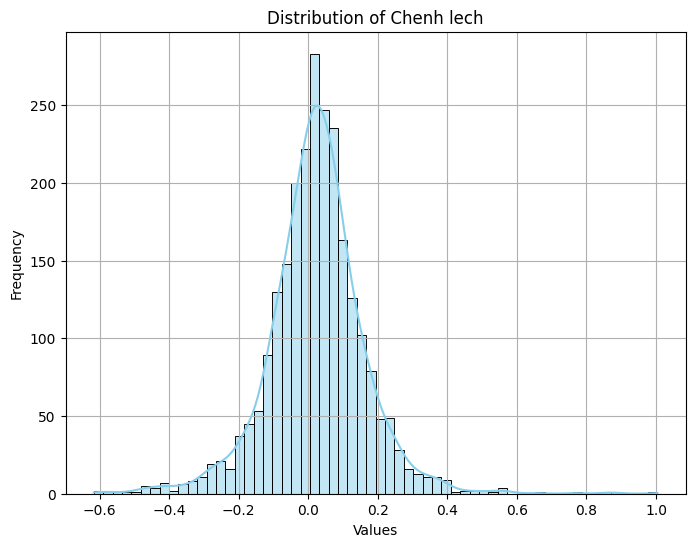

In [ ]:
# Vẽ biểu đồ phân bố của sự chênh lệch giữa giá dự đoán và giá thực tế
plt.figure(figsize=(8, 6))
sns.histplot((y_test - predicted_close), bins=60, color='skyblue', edgecolor='black', kde=True)
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.title('Distribution of Chenh lech')
plt.grid(True)
plt.show()